In [1]:
import cv2
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from u_net_modules import *

from u_net_modules import UNET_v3
from DATA_LOADER import *
import time
from torchsummary import summary
import torchviz
import matplotlib.pyplot as plt

import geopandas as gpd
import json
from torch.utils.data.dataset import Subset

In [2]:
# cfg
train=False
save_permission=False
patch=r'F:\mgr_datasets\PASTIS'

batch_size = 100
num_epochs=100

# folds:
folds_nb=4
training_folds=[[1,2,3],[4,1,2],[3,4,1],[2,3,4]]
validation_folds=[[4],[3],[2],[1]]
test_folds=[5]



log='results.txt'

if os.path.exists(log):
    os.remove(log)

with open(log, 'w') as file:
    file.write('Fold, Test Accuracy, Fold Time\n')  # Nagłówek kolumn

In [3]:
def accuracy(pred,target):

    correct=(pred==target).sum().item()

    total=target.numel()
    accuracy=correct/total

    return accuracy



def test_model(model,data_loader,criterion, device):
    
    model.eval()

    total_accuracy=0.0
    num_samples=0

    with torch.no_grad():
        for batch,target in data_loader:
            
            batch = batch.to(device)
            target = target.to(device)

            output = model(batch)
            loss = criterion(output,target)

            batch_accuracy = accuracy(output,target)

            batch_size=batch.size(0)
            total_accuracy+=batch_accuracy*batch_size
            num_samples+=batch_size
            print("testing")
    
    test_accuracy=total_accuracy/num_samples

    print(f"Test Accuracy: {test_accuracy:.4f}")



In [4]:
def create_fold_list(geojson_file,training_folds,validation_folds,test_folds):

    training_data=[]
    validation_data=[]
    test_data=[]

    for feature in geojson_file['features']:
        
        fold=feature['properties']['Fold']
        id_patch=feature['properties']['ID_PATCH']

        if fold in training_folds:
            training_data.append(id_patch)
        elif fold in validation_folds:
            validation_data.append(id_patch)
        elif fold in test_folds:
            test_data.append(id_patch)

    return training_data,validation_data,test_data
            


In [5]:
# Sprawdzenie dostępności GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available:
    device="cuda"
    print("GPU available")
else:
    device="cpu"
    print("GPU unavailable only CPU")


# Tworzymy instancję klasy Dataset
print("Data loading...")
input_folder = rf'{patch}\DATA_S2'
target_folder=rf'{patch}\ANNOTATIONS'
custom_dataset = CustomDataset(input_folder,target_folder)

print("Geodata loading...")
# geodata_frame=gpd.read_file()

with open(rf'{patch}\metadata.geojson','r') as file:
    geodata_frame = json.load(file)


print("Geodata loading successful")

# # Podział na dane testowe i treningowe
# dataset_size = len(custom_dataset)
# train_size = int(0.8 * dataset_size)  # 80% danych treningowych
# test_size = dataset_size - train_size

# # Dokonujemy losowego podziału na dane treningowe i testowe
# train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# train_ind=[]
# val_ind=[]
# test_ind=[]

# for idx,input_file_name in enumerate(custom_dataset.input_file_list):
#     input_file_id=input_file_name.split('_')[-1].split('.')[0]
#     if input_file_name in training_data:
#         train_ind.append(idx)

#     elif input_file_name in val_ind:
#         val_ind.append(idx)

#     elif input_file_name in test_ind:
#             test_ind.append(idx)

# train_dataset=Subset(custom_dataset,training_data)
# validation_dataset=Subset(custom_dataset,val_ind)
# test_dataset=Subset(custom_dataset,test_ind)


# Podział wg foldów


# for input_batch, target_batch in data_loader_train:
#     # print("Kształt danych wejściowych:", input_batch.shape)
#     # print("Kształt danych docelowych:", target_batch.shape)
#     break  # Wyświetlamy tylko pierwszy batch

print("Data loading successful")




print("Model initialization...")
# Tworzenie modelu sieci U-TAE
in_channels = 10  # Liczba kanałów wejściowych
out_channels = 20  # Liczba kanałów wyjściowych dla problemu klasyfikacji
sequence_length = 61  # Długość szeregu czasowego (ilość zdjęć w sekwencji)
height, width = 128, 128  # Rozmiary wymiarów przestrzennych
# model = UNET_v1(in_channels, out_channels,sequence_length)
model=UNET_v3(in_channels,out_channels)
model.to(device)  # Przenosimy model do GPU
print("Model ready")


GPU available
Data loading...
Geodata loading...
Geodata loading successful
Data loading successful
Model initialization...
Model ready


In [6]:


criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)



if train:
    print("Training...")

    loss_arr = np.empty((folds_nb, num_epochs))
    

    for fold in range(folds_nb):
        
        start_time=time.time()
        model.train()
        
        print(f'Fold nb: {fold+1} data initialization...')

        training_data, validation_data, test_data = create_fold_list(geodata_frame, training_folds[fold], validation_folds[fold], test_folds)
        # Tworzymy listy nazw plików docelowych na podstawie numerów plików
        training_files = [f'S2_{num}.npy' for num in training_data]
        validation_files = [f'S2_{num}.npy' for num in validation_data]
        # test_files = [f'S2_{num}.npy' for num in test_data]

        # Tworzymy listy indeksów plików na podstawie nazw plików
        train_ind = [idx for idx, input_file_name in enumerate(custom_dataset.input_file_list) if input_file_name in training_files]
        val_ind = [idx for idx, input_file_name in enumerate(custom_dataset.input_file_list) if input_file_name in validation_files]
        # test_ind = [idx for idx, input_file_name in enumerate(custom_dataset.input_file_list) if input_file_name in test_files]

        # Tworzymy zestawy danych na podstawie indeksów
        train_dataset = Subset(custom_dataset, train_ind)
        validation_dataset = Subset(custom_dataset, val_ind)
        # test_dataset = Subset(custom_dataset, test_ind)


        # Tworzymy DataLoader z użyciem collate_fn

        data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        data_loader_val=DataLoader(validation_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
        # data_loader_test=DataLoader(test_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
        print(f'Fold nb: {fold+1} data preapre successful')

        print(f'Fold nb: {fold+1} training')


        
        for epoch in range(num_epochs):
            # i=0
            
            # Teraz możemy iterować przez DataLoader i pobierać dane wsadowo podczas trenowania sieci
            for batch,target in data_loader_train:
                # if i%10==0:
                #     print("batches: ", i)
                # i=i+1
                batch = batch.to(device)
                optimizer.zero_grad()
                output,predictions=model(batch)
                
                target=target.to(device)
                # print('target size:',target.shape)

                # print('pred type', predictions.dtype)
                # print('target type', target.dtype)

                # output.requires_grad = True  # Dodaj to, aby umożliwić obliczanie gradientów dla predictions
                loss=criterion(output,target.long())

                loss.backward()
                optimizer.step()
                loss_arr[fold][epoch]=loss.item()
            # if epoch%50==0:
            print(f'Epoch[{epoch}/{num_epochs}]')
            

        end_time=time.time()    
        elapsed_time=end_time-start_time
        
        print(f'Fold [{fold+1}/{folds_nb}], Loss: {loss_arr[fold].mean()}')
        print(F'Training time per fold: {elapsed_time:.2f} s')

        model.eval()

        total_accuracy=0.0
        num_samples=0

        with torch.no_grad():
            for batch,target in data_loader_val:
                print("Validation...")
                batch = batch.to(device)
                target = target.to(device)

                output,pred = model(batch)
                loss = criterion(pred,target)

                batch_accuracy = accuracy(pred,target)

                batch_size=batch.size(0)
                total_accuracy+=batch_accuracy*batch_size
                num_samples+=batch_size
                

        
        test_accuracy=total_accuracy/num_samples

        fold_time=time.time()-start_time
        with open(log, 'a') as file:
            file.write(f'{fold+1}, {test_accuracy:.4f}, {fold_time:.2f}\n')
        print(f"Test Accuracy for fold nb {fold+1}: {test_accuracy:.4f}")
        print(f'Fold nb {fold+1} full time: {fold_time}')
        print('')
        

else:
    model.load_state_dict(torch.load(r'F:\pytong\unet_to_notimeseries_source\model.pth'))
    model.to(device)  # Przenosimy model do GPU
    model.eval()


In [7]:
if train and save_permission:
    torch.save(model.state_dict(),'model.pth')
    print('model_saved')
    True

In [8]:
if train:
    plt.plot(range(len(loss_arr)),loss_arr)
    plt.xlabel('epoch')
    plt.ylabel('loss')

In [9]:
if train:
    sample=2

    image_batch = predictions[sample, :, :].cpu().detach().numpy()

    source = batch[sample,3, :, :].cpu()

    image_target = target[sample, :, :].cpu()
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Tworzy jeden wiersz i dwa wykresy obok siebie

    # Pierwszy wykres dla image_batch
    axes[0].imshow(image_batch)
    axes[0].set_title('Predictions')

    # Drugi wykres dla image_target
    axes[1].imshow(image_target)
    axes[1].set_title('Target')

    axes[2].imshow(source)
    axes[2].set_title('Source')

    plt.show()

In [11]:
# test_model(model,data_loader_test,criterion,device)
training_data, validation_data, test_data = create_fold_list(geodata_frame, training_folds[0], validation_folds[0], test_folds)
model.eval()
test_files = [f'S2_{num}.npy' for num in test_data]
test_ind = [idx for idx, input_file_name in enumerate(custom_dataset.input_file_list) if input_file_name in test_files]
test_dataset = Subset(custom_dataset, test_ind)
data_loader_test=DataLoader(test_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)

total_accuracy=0.0
num_samples=0

with torch.no_grad():
    for batch,target in data_loader_test:
            
        batch = batch.to(device)
        target = target.to(device)

        output,pred = model(batch)
        loss = criterion(pred,target)

        batch_accuracy = accuracy(pred,target)

        batch_size=batch.size(0)
        total_accuracy+=batch_accuracy*batch_size
        num_samples+=batch_size
        print("testing")

  
test_accuracy=total_accuracy/num_samples

print(f"Test Accuracy: {test_accuracy:.4f}")


testing
testing
testing
testing
testing
Test Accuracy: 0.4001


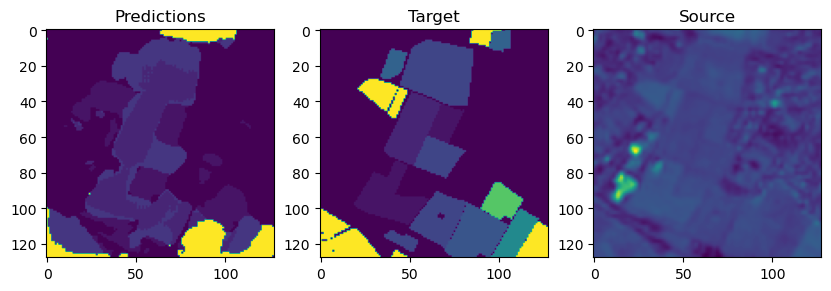

In [22]:
sample=12

image_batch = pred[sample, :, :].cpu().detach().numpy()

source = batch[sample,3, :, :].cpu()

image_target = target[sample, :, :].cpu()
fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Tworzy jeden wiersz i dwa wykresy obok siebie

# Pierwszy wykres dla image_batch
axes[0].imshow(image_batch)
axes[0].set_title('Predictions')

# Drugi wykres dla image_target
axes[1].imshow(image_target)
axes[1].set_title('Target')

axes[2].imshow(source)
axes[2].set_title('Source')

plt.show()

# Zaimportuj bibliotekę matplotlib
import matplotlib.pyplot as plt

# Przekopiuj tensor na urządzenie CPU i przekształć na numpy array
read_data = output[2, 0, :, :].cpu().numpy()

# Przeskaluj wartości do zakresu od 0 do 255
# scaled_image = (read_data ).astype(np.uint8)

# Utwórz unikalną listę etykiet
unique_labels = np.unique(read_data)

# Wybierz mapę kolorów z matplotlib (np. 'viridis', 'jet', 'coolwarm', 'rainbow', itp.)
cmap_name = 'viridis'

# Wygeneruj mapę kolorów na podstawie etykiet i wybranej mapy kolorów
cmap = plt.get_cmap(cmap_name, len(unique_labels))

# Wygeneruj obraz kolorowy na podstawie etykiet i mapy kolorów
colored_image = cmap(read_data)
plt.imshow(colored_image)
plt.show()


max_val=np.max(read_data)
min_val=np.min(read_data)

scaled_read=read_data

unique_1=np.unique(scaled_read)
print(len(unique_1))

print(np.max(scaled_read))
print(np.min(scaled_read))

plt.imshow(scaled_read)
plt.show()

img_from_batch=batch[2,0:3,1,:,:]
permute_img=img_from_batch.permute(1,2,0)





permute_img=permute_img

scaled_permute=(permute_img/7000)
plt.imshow(scaled_permute.cpu().numpy())
plt.show()





model.eval()
model_path=r'F:\pytong\utaeV2\MODEL\U_NET_V1.pth'
torch.save(model.state_dict(),model_path)